In [1]:
import re
import numpy as np
import pybedtools as pb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import signal, stats
from collections import defaultdict
from Bio import Align, SeqIO
from Bio.Align import AlignInfo

# Defining KZFP clusters
KZFPs are known to form tandemly repeated clusters in mammalian genomes. In this project, we would like to analyze the composition and regulatory activity of these clusters, in order to better understand the behaviour of KZFPs in development and disease states. To begin, we will simply define clusters based on their spatial organisation within the genome. To do this, we will use kernel density estimation to identify boundaries between clusters.

In [2]:
# Define some global data structures storing KZFP coordinates etc.
with open('../data/genome/GCF_009914755.1.genome') as infile:
    chr_lengths = {l.split()[0]: (0, int(l.split()[1])) for l in infile}

with open('../data/genome/GCF_009914755.1.chrom_accessions.txt') as infile:
    acc_to_chr = {l.split()[0]: l.split()[1] for l in infile}
    
transcript_to_kzfp = {}
with open('../data/gffs/kzfp_transcripts.gff') as infile:
    for line in infile:
        cds_mrna = re.search('ID=cds-(.+?);Parent=rna-(.+?);', line)
        if cds_mrna:
            cds, mrna = cds_mrna.groups()
            transcript_to_kzfp[mrna] = cds
    
kzfp_gff = pb.BedTool('../data/gffs/kzfp_transcripts_only.gff')

kzfp_midpoints = defaultdict(dict)
kzfp_boundaries = defaultdict(dict)
for feature in kzfp_gff:
    midpoint = int(feature.start + (feature.end - feature.start)/2)
    kzfp_midpoints[feature.chrom][feature.name.strip('rna-')] = midpoint
    kzfp_boundaries[feature.chrom][feature.name.strip('rna-')] = (feature.start, feature.end)

In [3]:
def extract_gene_clusters(chr_accession, margin=2e5, bandwidth=0.025):
    """Use kernel density estimation to assign KZFPs to clusters on a given chromosome.
    
    Arguments:
        chr_accession - Accession number for chromome of interest
        margin - slop from the edges of first and last genes in cluster
        bandwidth - KDE bandwith, i.e. cluster granularity
    Returns:
        gene_clusters - dictionary mapping from cluster to list of constituent genes
        cluster_boundaries - dictionary mapping start and end coordinates of clusters
    """
    gene_kde = stats.gaussian_kde(list(kzfp_midpoints[chr_accession].values()), 
                                  bw_method=bandwidth)
    start, stop, step = *chr_lengths[chr_accession], 10000
    gene_pdf = gene_kde.pdf([*range(start, stop, step)])
    # gene_minima = [0] + list(step*signal.argrelmin(gene_pdf)[0]) + [stop]
    gene_minima = [start] + list(step*signal.find_peaks(-gene_pdf)[0]) + [stop]
    
    # Assign genes to clusters using gend KDE minima as boundaries
    wide_cluster_boundaries = [(gene_minima[i], gene_minima[i+1]) for i in range(len(gene_minima)-1)]
    gene_clusters = []
    curr_cluster = []
    i = 0
    for gene, mp in kzfp_midpoints[chr_accession].items():
        start, stop = wide_cluster_boundaries[i]
        if mp > stop:
            i += 1
            gene_clusters.append(curr_cluster)
            curr_cluster = []
        curr_cluster.append(gene)
    gene_clusters.append(curr_cluster)
    gene_clusters = {i: cluster for i, cluster in enumerate(gene_clusters)}
    
    # Determine cluster boundaries
    cluster_boundaries = {}
    for i, cluster in gene_clusters.items():
        gene_coords = [kzfp_boundaries[chr_accession][gene] for gene in cluster]
        gene_coords = [i for j in gene_coords for i in j]
        # Set cluster boundaries as egde of first/last gene plus the margin, unless this exceeds chromosome boundaries.
        cluster_boundaries[i] = int(max((min(gene_coords)-margin, 0))), int(min((max(gene_coords)+margin, chr_lengths[chr_accession][1])))
    
    return gene_clusters, cluster_boundaries

def plot_clusters(chr_accession, margin=2e5, bandwidth=0.025):
    gene_clusters, cluster_boundaries = extract_gene_clusters(chr_accession, margin, bandwidth)
    data = []
    for i, cluster in gene_clusters.items():
        for gene in cluster:
            data.append([gene, kzfp_midpoints[chr_accession][gene], i])
        
    cluster_df = pd.DataFrame(data,
                              columns=['gene', 'midpoint', 'cluster'])
    
    fig, ax = plt.subplots(figsize=(8, 1))
    sns.kdeplot(cluster_df, 
                x='midpoint', 
                bw_method=bandwidth,
                lw=1,
                color='k',
                ax=ax)
    sns.rugplot(data=cluster_df, 
                x='midpoint',
                hue='cluster',
                height=0.075, 
                ax=ax)
    
    for cluster, (start, stop) in cluster_boundaries.items():
        if len(gene_clusters[cluster]) < 3:
            rect = patches.Rectangle((start, 0), stop-start, 1e-5, facecolor='whitesmoke')
        else:
            rect = patches.Rectangle((start, 0), stop-start, 1e-5, facecolor='#D9E0EA')
            ax.text(x=start + (stop-start)/2, y=1.3e-7, s=f'{len(gene_clusters[cluster])}', ha='center')
        ax.add_patch(rect)
    
    ax.set_xlim((chr_lengths[chr_accession][0], chr_lengths[chr_accession][1]))
    ax.set_xlabel(f'Chromosome {acc_to_chr[chr_accession]} position (bp)')
    ax.get_legend().remove()
    sns.despine()
    fig.savefig('/Users/jonwells/Desktop/chr19_cluster.pdf', bbox_inches='tight')
    plt.show()    

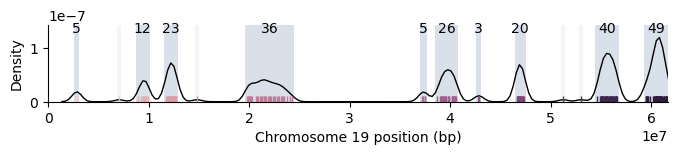

In [4]:
plot_clusters('NC_060943.1')

In [6]:
gc, mp = extract_gene_clusters('NC_060943.1', margin=2e5, bandwidth=0.025)
print(gc)

{0: ['NM_001102651.2', 'XM_054320006.1', 'NM_024967.3', 'NM_173480.3', 'NM_021217.3'], 1: ['NM_001044387.2'], 2: ['XM_054319987.1', 'NM_020933.5', 'NM_198535.3', 'NM_001202406.1', 'NM_001384659.1', 'NM_001172651.2', 'XM_054319552.1', 'XM_054319877.1', 'NM_024106.3', 'XM_054322661.1', 'NM_001130031.2', 'NM_001077624.3'], 3: ['NM_145295.4', 'NM_001080493.4', 'NM_152355.3', 'XM_054319755.1', 'NM_001348718.2', 'XM_054321983.1', 'NM_001271848.2', 'NM_001012753.2', 'XM_054320060.1', 'XM_054321925.1', 'NM_001136501.3', 'NM_021143.4', 'NM_145233.4', 'NM_003437.5', 'NM_001164276.2', 'NM_145276.3', 'NM_030824.3', 'NM_001080821.3', 'NM_005815.5', 'NM_152601.4', 'NM_144976.4', 'NM_020714.3', 'NM_153358.3'], 4: ['NM_032433.4'], 5: ['NM_033204.4', 'NM_021030.3', 'NM_001099269.3', 'NM_021047.3', 'NM_031218.4', 'XM_054322561.1', 'NM_007138.2', 'NM_052852.4', 'XM_054319449.1', 'NM_001412412.1', 'NM_001355197.2', 'XM_054321987.1', 'NM_025189.4', 'NM_182515.4', 'NM_001319124.2', 'NM_021269.3', 'NM_001355

NC_060925.1


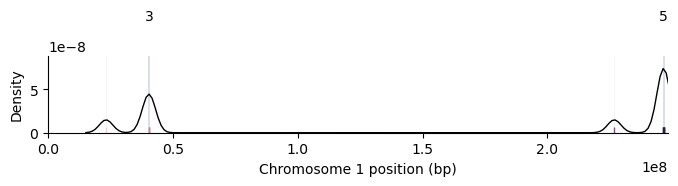

NC_060926.1
NC_060927.1


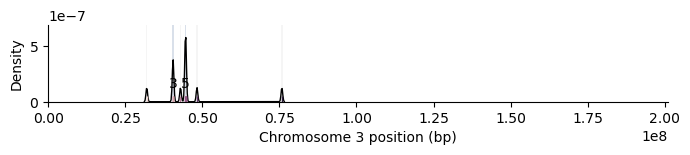

NC_060928.1


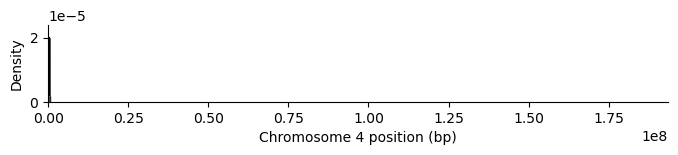

NC_060929.1


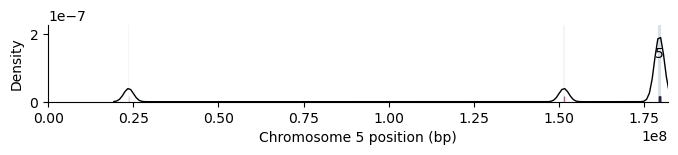

NC_060930.1


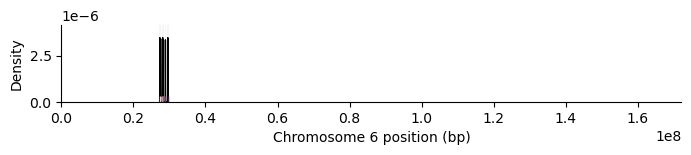

NC_060931.1


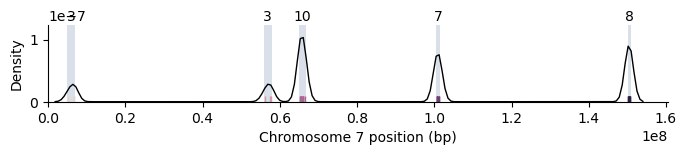

NC_060932.1


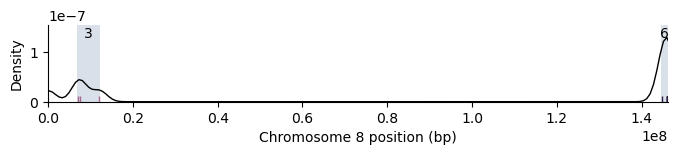

NC_060933.1


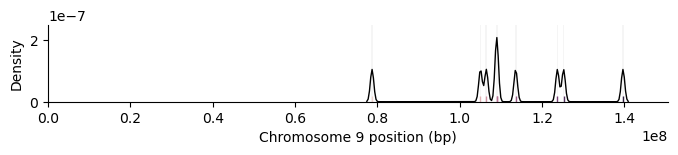

NC_060934.1


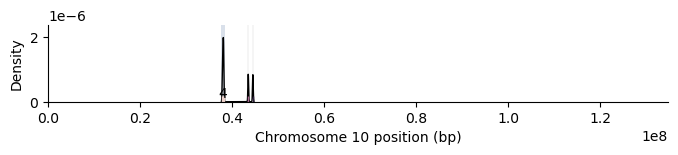

NC_060935.1
NC_060936.1


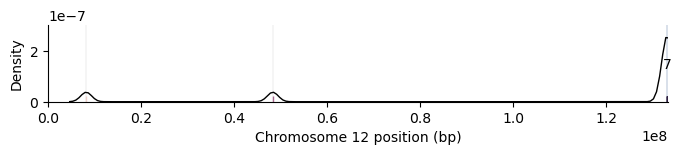

NC_060940.1


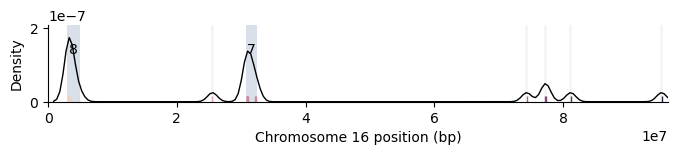

NC_060941.1
NC_060942.1
NC_060943.1


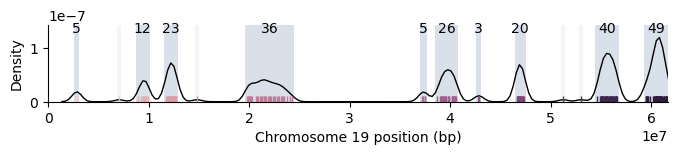

NC_060944.1
NC_060946.1
NC_060947.1


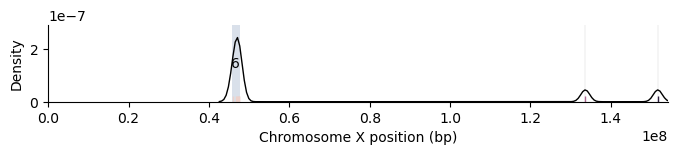

In [9]:
# Plot clusters for Chr 19
for chrom, kzfps in kzfp_midpoints.items():
    print(chrom)
    if len(kzfps) < 5:
        continue
    plot_clusters(chrom)

# Analysis of KZFP clusters
Having defined clusters based on kernel density estimates, we would like to begin analyzing the composition of clusters and comparing with that of the rest of the genome. To do this, we will represent our clusters in BED format in order for easy manipulation. We will use this to ask the following questions:

1. Is the TE content of ZKFP clusters higher than expected relative to random regions of the genome?
2. Are TEs within clusters younger than the rest of the genome?
3. Are they longer/shorter (i.e. more or less fragmented)?
4. Does the distance between TEs and KZFPs differ from that in other regions of the genome?

In [11]:
# Create_dictionaries mapping KZFPs to clusters and vice versa
kzfp_to_cluster = {}
cluster_to_kzfp = {}

# Create string that will be used to generate BED file containing cluster regions.
cluster_ranges = ''
for chrom, kzfps in kzfp_midpoints.items():
    if len(kzfps) < 5:
        continue
    c_count = 1
    clusters, cluster_boundaries = extract_gene_clusters(chrom)
    for cluster_key, cluster_contents in clusters.items():
        if len(cluster_contents) < 5:
            continue
        cluster_name = f'chr{acc_to_chr[chrom]}_c{c_count}'
        row = '\t'.join([chrom, str(cluster_boundaries[cluster_key][0]), str(cluster_boundaries[cluster_key][1]), cluster_name + '\n'])
        cluster_ranges += row
        
        for gene in cluster_contents:
            kzfp_to_cluster[gene] = cluster_name
        cluster_to_kzfp[cluster_name] = cluster_contents
        c_count += 1
        
cluster_bed = pb.BedTool(cluster_ranges, from_string=True)

# Load BED file of RepeatMasker output and merge intersect with clusters
te_bed = pb.BedTool('/Users/jonwells/Genomes/Mammalia/Hominoidea/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_rm.bed')
cluster_te_bed = cluster_bed.intersect(te_bed, wa=True, wb=True)

# Create randomly shuffled clusters and intersect with TEs
random_bed = []
# Random control dataset x100 the size of the observed
for i in range(50):
    if i %10 == 0:
        print(i)
    random_bed.append(cluster_bed.shuffle(g='../data/genome/GCF_009914755.1.genome'))
random_bed = random_bed[0].cat(*random_bed[1:], postmerge=False)
random_te_bed = random_bed.intersect(te_bed, wb=True)

0
10
20
30
40


In [12]:
# Convert to dataframe
colnames = ['kzfp_chrom', 'kzfp_start', 'kzfp_end', 'cluster_name', 'te_chrom', 'te_start', 'te_end', 'tename',
            'SW_score', 'strand', 'percent_div', 'perc_del', 'perc_ins', 'base_ext',
            'teclass', 'bp_complement', 'match_start', 'match_end', 'ins_id']

cluster_te_df = cluster_te_bed.to_dataframe(names=colnames)
cluster_te_df['data_type'] = 'observation'
cluster_te_df['tefam'] = cluster_te_df.teclass.apply(lambda x: x.split('/')[-1])
cluster_te_df['teclass'] = cluster_te_df.teclass.apply(lambda x: x.split('/')[0])

random_te_df = random_te_bed.to_dataframe(names=colnames)
random_te_df['data_type'] = 'control'
random_te_df['tefam'] = random_te_df.teclass.apply(lambda x: x.split('/')[-1])
random_te_df['teclass'] = random_te_df.teclass.apply(lambda x: x.split('/')[0])

experiment_df = pd.concat([random_te_df, cluster_te_df])
experiment_df['insertion_length'] = abs(experiment_df.te_start - experiment_df.te_end)
experiment_df

,kzfp_chrom,kzfp_start,kzfp_end,cluster_name,te_chrom,te_start,te_end,tename,SW_score,strand,...,perc_ins,base_ext,teclass,bp_complement,match_start,match_end,ins_id,data_type,tefam,insertion_length
0,NC_060928.1,150936491,150936521,chr1_c1,NC_060928.1,150936400,150936521,MER119,405,+,...,0.0,(42638424),DNA,1,128,(455),1299026,control,hAT-Charlie,121
1,NC_060928.1,150936529,150936654,chr1_c1,NC_060928.1,150936529,150936654,MER119,677,+,...,0.0,(42638291),DNA,456,583,(0),1299027,control,hAT-Charlie,125
2,NC_060928.1,150937085,150937133,chr1_c1,NC_060928.1,150937085,150937133,MER58C,282,-,...,0.0,(42637812),DNA,(0),215,167,1299028,control,hAT-Charlie,48
3,NC_060928.1,150937170,150937616,chr1_c1,NC_060928.1,150937170,150937616,L1MB4,2539,+,...,0.4,(42637329),LINE,5657,6115,(65),1299029,control,L1,446
4,NC_060928.1,150938031,150938620,chr1_c1,NC_060928.1,150938031,150938620,MLT1G,2370,-,...,3.9,(42636325),LTR,(0),591,3,1299030,control,ERVL-MaLR,589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69303,NC_060947.1,45704680,47681280,chrX_c1,NC_060947.1,46006071,46006300,MER58A,1126,-,...,4.0,(108253266),DNA,(0),224,3,4512579,observation,hAT-Charlie,229
69304,NC_060947.1,45704680,47681280,chrX_c1,NC_060947.1,46399318,46399633,L1MDa,736,-,...,2.6,(107859933),LINE,(6116),635,66,4513325,observation,L1,315
69305,NC_060947.1,45704680,47681280,chrX_c1,NC_060947.1,46792605,46792951,MER21-int,1845,+,...,0.0,(107466615),LTR,829,1188,(3003),4514190,observation,ERVL,346
69306,NC_060947.1,45704680,47681280,chrX_c1,NC_060947.1,47054243,47055117,L2a,894,-,...,0.9,(107204449),LINE,(2),3424,2418,4514762,observation,L2,874


In [13]:
cluster_colnames = ['chrom', 'start', 'end', 'cluster_name', 'nfeatures_overlap', 'nbases_nonzero', 'lenfeature', 'perc_coverage']

cluster_coverage = cluster_bed.coverage(te_bed)
cluster_cov_df = cluster_coverage.to_dataframe(names=cluster_colnames)
cluster_cov_df['data_type'] = 'observation'

random_coverage = random_bed.sort().coverage(te_bed)
random_cov_df = random_coverage.to_dataframe(names=cluster_colnames)
random_cov_df['data_type'] = 'control'

cov_experiment_df = pd.concat([cluster_cov_df, random_cov_df])
cov_experiment_df.perc_coverage *= 100

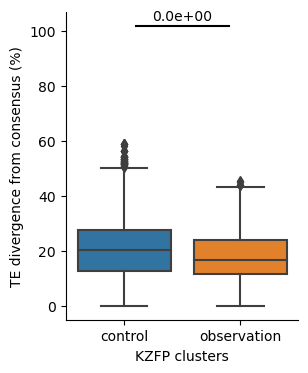

In [47]:
fig, ax = plt.subplots(figsize=(3, 4))

sns.boxplot(data=experiment_df, x='data_type', y='percent_div')

pval = stats.ranksums(experiment_df.loc[experiment_df.data_type == 'observation', 'percent_div'],
                      experiment_df.loc[experiment_df.data_type == 'control', 'percent_div'])

plt.plot((0.1, 0.9), (102, 102), color='k')
plt.text(0.5, 104, f'{pval[1]:.1e}', ha='center')

ax.set_ylabel('TE divergence from consensus (%)')
ax.set_xlabel('KZFP clusters')
# ax.set_xticklabels(['observed', 'shuffled'])

sns.despine()
plt.show()

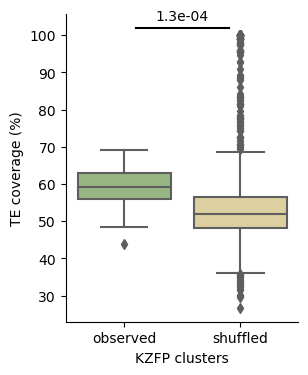

In [70]:
fig, ax = plt.subplots(figsize=(3, 4))

sns.boxplot(data=cov_experiment_df, x='data_type', y='perc_coverage', palette=['#95BE7C', '#E7D595'])

pval = stats.ranksums(cov_experiment_df.loc[cov_experiment_df.data_type == 'observation', 'perc_coverage'],
                      cov_experiment_df.loc[cov_experiment_df.data_type == 'control', 'perc_coverage'])

plt.plot((0.1, 0.9), (102, 102), color='k')
plt.text(0.5, 104, f'{pval[1]:.1e}', ha='center')

ax.set_ylabel('TE coverage (%)')
ax.set_xlabel('KZFP clusters')
ax.set_xticklabels(['observed', 'shuffled'])

sns.despine()
plt.savefig('/Users/jonwells/Desktop/te_coverage.jpg')
plt.show()

In [23]:
te_df = cluster_te_df[['te_chrom', 'te_start', 'te_end', 'tename', 'tefam', 'teclass', 'strand']] \
    .rename({'tename': 'name', 'te_chrom': 'seqname', 'te_start': 'start', 'te_end': 'end'}, axis=1)
te_df['attributes'] = te_df.name + ':' + te_df.tefam + ':' + te_df.teclass
te_df = te_df.drop(['tefam', 'teclass'], axis=1)
te_df['score'] = '.'
processed_te_bed = pb.BedTool.from_dataframe(te_df[['seqname', 'start', 'end', 'name', 'score', 'strand']]).sort()

def extract_genename(row):
    hit = re.search(r'Parent=gene-(.+?);', row)
    if hit:
        return hit.group(1)
    else:
        return 'NA'

kzfp_df = kzfp_gff.to_dataframe()[['seqname', 'start', 'end', 'score', 'strand', 'attributes']]
kzfp_df['name'] = kzfp_df['attributes'].apply(extract_genename)
kzfp_bed = pb.BedTool.from_dataframe(kzfp_df[['seqname', 'start', 'end', 'name', 'score', 'strand']]).sort()

dist_df = kzfp_bed.closest(processed_te_bed, io=True, s=True, id=True, D='a') \
                  .to_dataframe(names=['kzfp_chrom', 'kzfp_start', 'kzfp_end', 'kzfp_name', 'kzfp_score', 'kzfp_strand',
                                       'te_chrom', 'te_start', 'te_end', 'te_name', 'te_score', 'te_strand', 'dist'])

In [24]:
dist_df2 = dist_df.loc[dist_df.te_chrom == 'NC_060943.1']
dist_df2.head()

,kzfp_chrom,kzfp_start,kzfp_end,kzfp_name,kzfp_score,kzfp_strand,te_chrom,te_start,te_end,te_name,te_score,te_strand,dist
137,NC_060943.1,2795155,2812024,ZNF554,.,+,NC_060943.1,2794523,2794823,AluSx,.,+,-333
138,NC_060943.1,2817450,2835759,ZNF555,.,+,NC_060943.1,2817143,2817199,(CCCCG)n,.,+,-252
139,NC_060943.1,2842602,2858723,ZNF556,.,+,NC_060943.1,2840612,2841103,LTR15,.,+,-1500
140,NC_060943.1,2876161,2892540,ZNF57,.,+,NC_060943.1,2875246,2875547,AluY,.,+,-615
141,NC_060943.1,2906814,2918459,ZNF77,.,-,NC_060943.1,2920485,2920702,L1MC5a,.,-,-2027


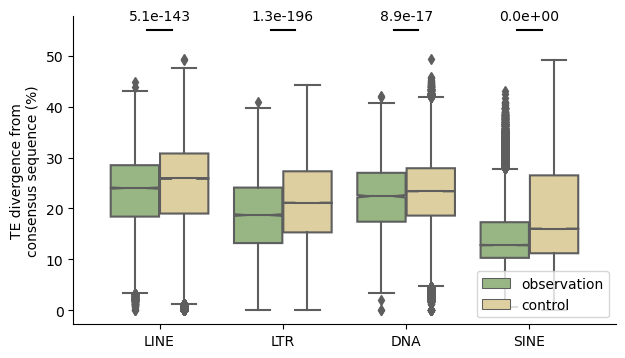

In [69]:
fig, ax = plt.subplots(figsize=(7, 4))

teclasses = ['LINE', 'LTR', 'DNA', 'SINE']

sns.boxplot(data=experiment_df.loc[experiment_df.teclass.isin(teclasses)], 
            x='teclass',
            y='percent_div',
            hue='data_type',
            palette=['#95BE7C', '#E7D595'],
            hue_order=['observation', 'control'],
            order=teclasses,
            notch=True,
            ax=ax)

for i, teclass in enumerate(teclasses):
    pval = stats.ranksums(experiment_df.loc[(experiment_df.teclass == teclass) & (experiment_df.data_type == 'control'), 'percent_div'],
                          experiment_df.loc[(experiment_df.teclass == teclass) & (experiment_df.data_type == 'observation'), 'percent_div'])
    
    plt.plot((i+0.1, i-0.1), (55, 55), color='k')
    plt.text(i, 57, f'{pval[1]:.1e}', ha='center')

    
ax.set_ylabel('TE divergence from\nconsensus sequence (%)')
ax.set_xlabel('')

sns.despine()
plt.legend(loc='lower right')
plt.savefig('/Users/jonwells/Desktop/te_age.jpg')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(data=experiment_df.loc[(experiment_df.cluster_name == 'chr7_c3') & (experiment_df.teclass.isin(['LINE', 'LTR', 'DNA', 'SINE']))], 
            x='teclass',
            y='percent_div',
            hue='data_type',
            order = ['LTR', 'LINE', 'SINE', 'DNA'],
            notch=True,
            ax=ax)
ax.set_yscale('log')
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
# sns.boxplot(data=experiment_df.loc[(experiment_df.data_type=='observation') & (experiment_df.teclass.isin(['LINE', 'LTR', 'DNA', 'SINE']))], 
sns.boxplot(data=experiment_df.loc[(experiment_df.tename == 'LTR66')], 
            x='cluster_name',
            hue='data_type',
            y='percent_div',
            ax=ax)
# ax.set_yscale('log')
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=cluster_te_df.loc[(cluster_te_df.tefam == 'ERVL') & (cluster_te_df.cluster_name == 'chr19_c4')], 
            x='tename',
            y='percent_div',
            ax=ax)
sns.stripplot(data=cluster_te_df.loc[(cluster_te_df.tefam == 'ERVL') & (cluster_te_df.cluster_name == 'chr19_c4')], 
            x='tename',
            y='percent_div',
            ax=ax)
sns.despine()
plt.show()

In [ ]:
tefam = 'HERVL66-int'

for cluster in sorted(set(cluster_te_df.cluster_name)):
    print(cluster)
    # Get expected background from other clusters
    total_insertions_other_clusters = cluster_te_df.loc[cluster_te_df.cluster_name != cluster, 'tename'].count()
    total_L1_insertions_other_clusters = cluster_te_df.loc[(cluster_te_df.cluster_name != cluster) & (cluster_te_df.tename == tefam), 'tename'].count()

    # Get sample size for observed cluster
    total_insertions_cluster = cluster_te_df.loc[cluster_te_df.cluster_name == cluster, 'tename'].count()
    total_L1_insertions_cluster = cluster_te_df.loc[(cluster_te_df.cluster_name == cluster) & (random_te_df.tename == tefam), 'tename'].count()
    
    print(total_insertions_other_clusters,
          total_L1_insertions_other_clusters,
          total_insertions_cluster,
          total_L1_insertions_cluster)
    
    hg = stats.hypergeom(total_insertions_other_clusters, total_L1_insertions_other_clusters, total_insertions_cluster)
    x = [*range(0, int(hg.mean())*5, 1)]
    # x = [*range(0, total_insertions_cluster, 5)]
    y = hg.pmf(x)
    
    fig = plt.figure(figsize=(8, 1))
    plt.plot(x, y)
    plt.axvline(x=total_L1_insertions_cluster)
    plt.axvline(x=hg.mean(), color='r')
    
    nkzfp = len(cluster_to_kzfp[cluster])
    
    plt.title(f'{cluster}; KZFPs={nkzfp}')
    sns.despine()
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
# sns.boxplot(data=experiment_df.loc[experiment_df.teclass.isin(['LTR', 'SINE', 'LINE', 'DNA', 'RC'])], 
#             x='teclass', 
#             y='percent_div', 
#             hue='data_type', 
#             notch=True,
#             ax=ax)
sns.violinplot(data=experiment_df.loc[experiment_df.teclass.isin(['SINE'])], 
            x='tefam', 
            y='percent_div', 
            hue='data_type', 
            # notch=True,
            ax=ax)

sns.despine()
plt.show()

In [ ]:
pd.set_option('display.max_rows', None)
print(experiment_df.loc[experiment_df.teclass.isin(['Satellite'])] \
      .groupby(['cluster_name', 'data_type', 'teclass'])['kzfp_chrom'] \
      .count())

## Analysis of cluster sequences
Let's begin looking at the sequence similarity within clusters.

In [ ]:
def kmers_entropy(seq, kmersize=4):
    kmers = defaultdict(int)
    for i in range(len(seq) - kmersize):
        kmers[seq[i:i+kmersize]] += 1
    tot_kmers = sum(kmers.values())
    for kmer, count in kmers.items():
        kmers[kmer] = count/tot_kmers
    return stats.entropy(list(kmers.values()))

In [ ]:
cluster_seqs = cluster_bed.sequence(fi='/Users/jonwells/Genomes/Mammalia/Hominoidea/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna')
cluster_records = SeqIO.parse(cluster_seqs.seqfn, 'fasta')
with open('../data/seqs/kzfp_clusters.fa', 'w') as f:
    SeqIO.write(handle=f, sequences=cluster_records, format='fasta')

# random_seqs = cluster_bed.shuffle(g='../data/GCF_009914755.1.genome').sequence(fi='/Users/jonwells/Genomes/Mammalia/Hominoidea/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna')
# random_records = SeqIO.parse(random_seqs.seqfn, 'fasta')

# for record, random_record in zip(cluster_records, random_records):
#     print('observed:', kmers_entropy(record.seq))
#     random_seq = [c for c in record.seq]
#     np.random.shuffle(random_seq)
#     random_seq = ''.join(random_seq)
#     print('shuffled seq:', kmers_entropy(random_seq))       
#     print('random:', kmers_entropy(random_record.seq))
#     print()

In [ ]:
def identity(s1, s2):
    return sum(i == j for i, j in zip(s1, s2))/len(s1)

In [ ]:
kzfp_seqdict = SeqIO.to_dict(SeqIO.parse('../data/seqs/krab_zfps.fa', 'fasta'))

aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")

cdict = defaultdict(list)
c_name = 0
for chrom, chrom_kzfps in kzfp_midpoints.items():
    if len(chrom_kzfps) < 5:
        continue
    clusters, _ = extract_gene_clusters(chrom, kzfp_midpoints, chr_lengths)
    for cluster in clusters:
        kzfps = [transcript_to_kzfp[tid[0]] for tid in cluster]
        if len(cluster) < 5:
            continue
        print(c_name, chrom, len(cluster))
        for i, seqi in enumerate(kzfps):
            for j, seqj in enumerate(kzfps):
                if j >= i:
                    continue
                proti, protj = kzfp_seqdict[seqi], kzfp_seqdict[seqj]
                ali = aligner.align(proti.seq, protj.seq)
                ali = AlignInfo.SummaryInfo(ali[0]).alignment
                
                cdict[c_name].append((proti.name, protj.name, identity(*ali)))
        c_name += 1

print()
        
for cname, values in cdict.items():
    pid = np.median([i[2] for i in values])
    mid = np.max([i[2] for i in values])
    print(cname, pid, mid)
    

In [ ]:
kzfp_seqdict = SeqIO.to_dict(SeqIO.parse('../data/seqs/krab_zfps.fa', 'fasta'))
cdict = {}
c = 0
for chrom, chrom_kzfps in kzfp_midpoints.items():
    if len(chrom_kzfps) < 5:
        continue
    clusters, _ = extract_gene_clusters(chrom, kzfp_midpoints, chr_lengths)
    for cluster in clusters:
        if len(cluster) < 5:
            continue
        kzfps = [transcript_to_kzfp[tid[0]] for tid in cluster]
        combinedseq = ''.join([str(kzfp_seqdict[label].seq) for label in kzfps])
        obs_ke = kmers_entropy(combinedseq, 5)
        exp_ke = []
        for _ in range(10):
            shuffledseq = [c for c in combinedseq]
            np.random.shuffle(shuffledseq)
            exp_ke.append(kmers_entropy(''.join(shuffledseq), 5))
        exp_ke  = np.mean(exp_ke)   
        cdict[c] = (chrom, len(cluster), obs_ke, exp_ke, obs_ke/exp_ke)
        c += 1

In [ ]:
for c, val in cdict.items():
    print(c, val)